Jupyter notebook used to test and compare all the se_resnet models: se_resnet34, se_resnet50, se_resnet101 and se_resnet152.
I have used Google Colaboratory to test the model.
Follow the README file for instructions on how to setup the Google Drive file to be able to replicate this.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the project folder
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/DeepfakeDetectionFolder'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DeepfakeDetectionModel'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Dataset', 'Code', 'Models', 'resnet34_train.ipynb', 'resnet50_train.ipynb', 'resnet101_train.ipynb', 'resnet152_train.ipynb', 'compare_resnet_models.ipynb', 'se_resnet34_train.ipynb', 'se_resnet50_train.ipynb', 'se_resnet101_train.ipynb', 'se_resnet152_train.ipynb', 'Copy of compare_resnet_models.ipynb']


In [3]:
# set paths to models, dataset and code folder
MODELS_FOLDER = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
DATASET_FOLDER = os.path.join(GOOGLE_DRIVE_PATH, 'Dataset', 'Dataset_Cropped')
CODE_FOLDER = os.path.join(GOOGLE_DRIVE_PATH, 'Code')
print(os.listdir(MODELS_FOLDER))
print(os.listdir(DATASET_FOLDER))
print(os.listdir(CODE_FOLDER))

['resnet34', 'resnet50', 'resnet101', 'resnet152', 'se_resnet34', 'se_resnet50', 'se_resnet101', 'se_resnet152']
['.DS_Store', 'train', 'test']
['resnet34.py', '__pycache__', 'calculate_mean_std.py', 'resnet50.py', 'resnet152.py', 'resnet101.py', 'se_resnet34.py', 'se_resnet50.py', 'se_resnet101.py', 'se_resnet152.py']


In [4]:
# necessary to be able to load the functions from the code folder
%load_ext autoreload
%autoreload 2

In [5]:
# append code folder to system
import sys
sys.path.append(CODE_FOLDER)

In [6]:
# import function to calculate mean and std values
from calculate_mean_std import calculate_mean_std

In [7]:
# setup test dataset path
test_dataset_path = os.path.join(DATASET_FOLDER, 'test')

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#load all the models
se_resnet34 = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, 'se_resnet34'))
#plot_model(resnet34, show_shapes=True, show_layer_names=True)
#resnet34.summary()

se_resnet50 = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, 'se_resnet50'))
#plot_model(resnet50, show_shapes=True, show_layer_names=True)
#resnet50.summary()

se_resnet101 = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, 'se_resnet101'))
#plot_model(resnet101, show_shapes=True, show_layer_names=True)
#resnet101.summary()

se_resnet152 = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, 'se_resnet152'))
#plot_model(resnet152, show_shapes=True, show_layer_names=True)
#resnet152.summary()

In [10]:
# calcualte average mean and std value to be used after to normalize the test dataset
stats_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

stats_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=stats_transform)

stats_loader = DataLoader(stats_dataset, batch_size=4, shuffle=True, num_workers=2)

calc_mean, calc_std = calculate_mean_std(stats_loader)

print(f'Mean: {calc_mean}')
print(f'Std: {calc_std}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Mean: tensor([0.5764, 0.4331, 0.3886])
Std: tensor([0.2170, 0.1732, 0.1617])


In [11]:
# apply transformations to the test dataset
transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=calc_mean, std=calc_std),
])

test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=transform)

In [12]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dataset_path)

Found 308 files belonging to 3 classes.


In [13]:
# make predictions using each model
model_names = [se_resnet34, se_resnet50, se_resnet101, se_resnet152]
model_strings = ['Se_ResNet34', 'Se_ResNet50', 'Se_ResNet101', 'Se_ResNet152']

results = {}

for model_name, model_string in zip(model_names, model_strings):
  model = model_name

  loss, accuracy = model.evaluate(test_dataset)

  results[model_string] = {'loss': loss, 'accuracy': accuracy}

10/10 [==============================] - 270s 26s/step - loss: 2.0936 - accuracy: 0.5390


In [14]:
print(results)

{'Se_ResNet34': {'loss': 2.191983222961426, 'accuracy': 0.6623376607894897}, 'Se_ResNet50': {'loss': 1.7411998510360718, 'accuracy': 0.649350643157959}, 'Se_ResNet101': {'loss': 1.951454997062683, 'accuracy': 0.37662336230278015}, 'Se_ResNet152': {'loss': 2.0935757160186768, 'accuracy': 0.5389610528945923}}


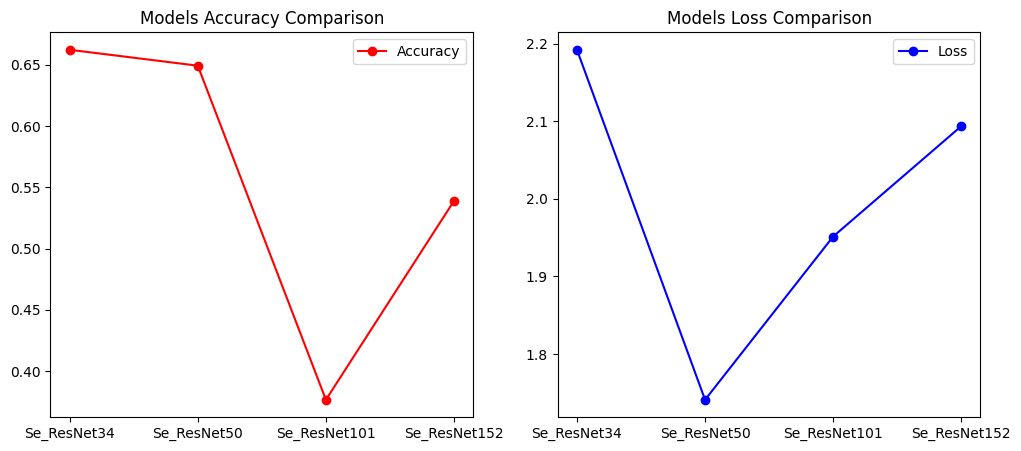

In [15]:
# plot accuracy values for each model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model_strings, [results[name]['accuracy'] for name in model_strings], 'ro-', label='Accuracy')
plt.title('Models Accuracy Comparison')
plt.legend()

# plot loss values for each model
plt.subplot(1, 2, 2)
plt.plot(model_strings, [results[name]['loss'] for name in model_strings], 'bo-', label='Loss')
plt.title('Models Loss Comparison')
plt.legend()

plt.show()